In [ ]:
!pip install plot_keras_history

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 15 21:39:26 2020

@author: isswan
"""
from __future__ import print_function
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import pandas as pd
from keras.preprocessing.text import Tokenizer, one_hot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from plot_keras_history import plot_history


In [ ]:
#Data Preparation
import pandas as pd
news=pd.read_table('drive/My Drive/Colab Data/r8-full-data.txt',header=None,names = ["Class", "Text"])
news.head()
a = news.groupby("Class")
a.head()
a.describe()
y=news['Class']
X=news['Text']

##check the length to determine the document length for DNN

length=news['Text'].apply(len)
news=news.assign(Length=length)

#Plot the distribution of the document length for each category
import matplotlib.pyplot as plt
news.hist(column='Length',by='Class',bins=50)

plt.figure()

In [7]:
#Data Preprocessing 

# Split train & test
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X_train) # longest text in train set
print('vocabubary size:',vocab_size)
print('max length text:',maxlen)

#fixed length for improved efficiency
MAX_LEN=100 
maxlen=MAX_LEN

#Padding the sentences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#embedding dimension should align with the GLOVE
embedding_dim = 100
vocab_size = len(word_index) + 1

GLOVE_6B_100D_PATH ="drive/My Drive/Colab Data/glove.6B.100d.txt"
encoding="utf-8"
with open(GLOVE_6B_100D_PATH, "rb") as lines:
    embeddings_index = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

# Prepare embedding matrix from pre-trained model
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)   

vocabubary size: 19998
max length text: 964
0.848034803480348


In [8]:
#create class weight dict for unbanlanced dataset
#If 'balanced', class weights will be given by n_samples / (n_classes * np.bincount(y)

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_d = dict(enumerate(class_weights))

##onehot encoding for y
def categoricalList2Onehot(listOfClasses):
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(listOfClasses)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

y_train_onehot = categoricalList2Onehot(y_train)
y_train_onehot.shape
y_test_onehot = categoricalList2Onehot(y_test)
y_test_onehot.shape

(2303, 8)

In [20]:
#Define the BiLSTM model with output Dropout
##############################################
model_out_dp = Sequential()
model_out_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model_out_dp.add(Bidirectional(LSTM(64)))
#output Dropout
model_out_dp.add(Dropout(0.5))
model_out_dp.add(Dense(8, activation='softmax'))

# try using different optimizers and different optimizer configs
model_out_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_out_dp.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 100)          1999800   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 128)               84480     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 1032      
Total params: 2,085,312
Trainable params: 85,512
Non-trainable params: 1,999,800
_________________________________________________________________


Train...
Train on 5371 samples, validate on 2303 samples
Epoch 1/5
5371/5371 [==============================] - 42s 8ms/step - loss: 0.9631 - accuracy: 0.6961 - val_loss: 0.5535 - val_accuracy: 0.8198
Epoch 2/5
5371/5371 [==============================] - 41s 8ms/step - loss: 0.4986 - accuracy: 0.8304 - val_loss: 0.3746 - val_accuracy: 0.8789
Epoch 3/5
5371/5371 [==============================] - 40s 8ms/step - loss: 0.4044 - accuracy: 0.8684 - val_loss: 0.3344 - val_accuracy: 0.8858
Epoch 4/5
5371/5371 [==============================] - 41s 8ms/step - loss: 0.3326 - accuracy: 0.8918 - val_loss: 0.3145 - val_accuracy: 0.8993
Epoch 5/5
5371/5371 [==============================] - 8s 2ms/step
Training Accuracy: 0.9211
Testing Accuracy:  0.9010


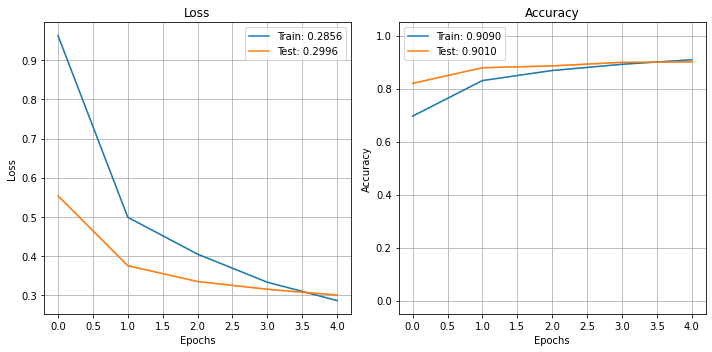

In [22]:
#Train the model
batch_size = 64

print('Train...')
hist_out_dp = model_out_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=5,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_out_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_out_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_out_dp)

In [ ]:
#Input Layer Dropout. 
###############################################################################
model_input_dp = Sequential()
model_input_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#Input Dropout
model_input_dp.add(Bidirectional(LSTM(64,dropout=0.5)))
model_input_dp.add(Dense(8, activation='softmax'))
# try using different optimizers and different optimizer configs
model_input_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_input_dp.summary()

In [ ]:
#Train the model
batch_size = 64

print('Train...')
hist_input_dp = model_input_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=5,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_input_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_input_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_input_dp)

In [ ]:
#recurent_dropout
###############################################################################
model_rec_dp = Sequential()
model_rec_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#recurent_dropout
model_rec_dp.add(Bidirectional(LSTM(64,recurrent_dropout=0.5)))
model_rec_dp.add(Dense(8, activation='softmax'))

# try using different optimizers and different optimizer configs
model_rec_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_rec_dp.summary()


In [ ]:
#Train the model
batch_size = 64

print('Train...')
hist_rec_dp = model_rec_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=5,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_rec_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_rec_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_rec_dp)

In [ ]:
#Combain all dropout
##############################################################################
model_all_dp = Sequential()
model_all_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#Input Dropout and rec Dropout
model_all_dp.add(Bidirectional(LSTM(64,dropout=0.5,recurrent_dropout=0.5)))
#output Dropout
model_all_dp.add(Dropout(0.5))
model_all_dp.add(Dense(8, activation='softmax'))
# try using different optimizers and different optimizer configs
model_all_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_all_dp.summary()

Train...
Train on 5371 samples, validate on 2303 samples
Epoch 1/5
5371/5371 [==============================] - 47s 9ms/step - loss: 1.2542 - accuracy: 0.5788 - val_loss: 0.8139 - val_accuracy: 0.6956
Epoch 2/5
5371/5371 [==============================] - 47s 9ms/step - loss: 0.8228 - accuracy: 0.7146 - val_loss: 0.6087 - val_accuracy: 0.7755
Epoch 3/5
5371/5371 [==============================] - 47s 9ms/step - loss: 0.7209 - accuracy: 0.7516 - val_loss: 0.5140 - val_accuracy: 0.8189
Epoch 4/5
5371/5371 [==============================] - 46s 9ms/step - loss: 0.6296 - accuracy: 0.7809 - val_loss: 0.4553 - val_accuracy: 0.8441
Epoch 5/5
5371/5371 [==============================] - 8s 2ms/step
Training Accuracy: 0.8674
Testing Accuracy:  0.8580


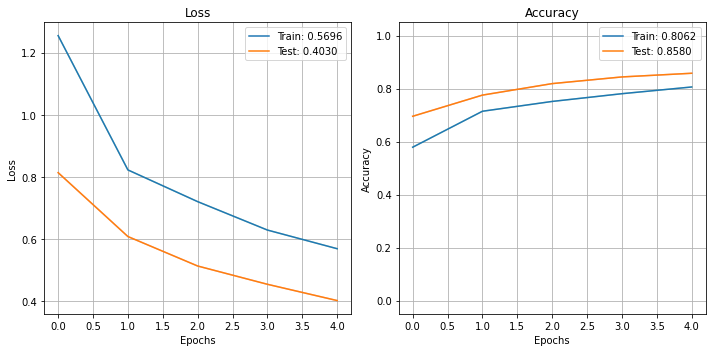

In [21]:
#Train the model
batch_size = 64

print('Train...')
hist_all_dp = model_all_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=5,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_all_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_all_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_all_dp)

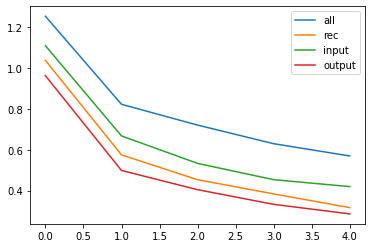

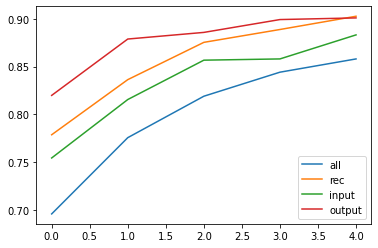

In [23]:
#Compare all the models

plt.plot(hist_all_dp['loss'], label='all')
plt.plot(hist_rec_dp['loss'], label='rec')
plt.plot(hist_input_dp['loss'], label='input')
plt.plot(hist_out_dp['loss'], label='output')
plt.legend(loc='upper right')
plt.show()

plt.plot(hist_all_dp['val_accuracy'], label='all')
plt.plot(hist_rec_dp['val_accuracy'], label='rec')
plt.plot(hist_input_dp['val_accuracy'], label='input')
plt.plot(hist_out_dp['val_accuracy'], label='output')
plt.legend(loc='lower right')
plt.show()
